# TextCNN (ver.Kkma)

In [813]:
from tensorflow import keras
import pandas as pd
import numpy as np
import pymysql
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Embedding, Dense, GRU, Bidirectional, Conv1D, GlobalMaxPooling1D, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [814]:
import pandas as pd
import pymysql

conn = pymysql.connect(
    host='34.64.240.96'
    , user='root'
    , password='tndusWkd1.'
    , db='final_project'
    , charset='utf8'
)
cur = conn.cursor()


In [815]:
news = pd.read_csv('./La.csv', index_col=0)
news['stock_id'] = '012450'

In [816]:
import re

def str_to_list(d):
  text = re.sub(r'[\[\'\]]', '', d)
  return text.split(", ")

news["token"] = news.token.apply(str_to_list)

In [817]:
from tqdm import tqdm
def stopword(x):
  stopword = [r'상승.*', r'하락.*', r'급등.*', r'급락.*', '상승세', '하락세', '폭등', '폭락', '오름세', '약세', '강세', '의', '가', '이', '은', '들', '는', '좀', '잘', '걍', '과', '도', '를', '으로', '자', '에', '와', '한', '하다', '에', '은', '는', '하']
  return [i for i in x if i not in stopword and not i.isdigit()]
tqdm.pandas()
news["token"] = news.token.progress_apply(stopword)
news

100%|██████████| 1407/1407 [00:00<00:00, 7610.79it/s]


,stock_id,date_time,title,content,token,open,high,low,close,volume,Accumulated sales volume,Accumulated number of contract,label,token_okt
0,012450,2023-06-28 14:53:00,"2023 방위산업 부품 장비대전 및 첨단국방산업전, 28일 개막",사이트,[사이트],127000.0,127100.0,126900.0,126900.0,2860.0,250497.0,187111.0,0,['사이트']
1,012450,2023-06-28 14:20:00,"한화에어로, K9 이어 ‘잠수함 배터리’로 인도 시장 정조준 [비즈360]",한화에어로 임원 인도 현지 언론과 인터뷰잠수함용 리튬이온배터리 수출 적극 검토한화에...,"[한화, 어로, 임원, 인도, 현지, 언론, 인터뷰, 잠수함, 용, 리튬, 이온, ...",127400.0,127500.0,127400.0,127500.0,436.0,220243.0,166780.0,1,"['한화', '에어로', '임원', '인도', '현지', '언론', '과', '인터..."
2,012450,2023-06-28 14:20:00,"한화에어로, K9 이어 ‘잠수함 배터리’로 인도 시장 정조준 [비즈360]",한화에어로 임원 인도 현지 언론과 인터뷰잠수함용 리튬이온배터리 수출 적극 검토한화에...,"[한화, 어로, 임원, 인도, 현지, 언론, 인터뷰, 잠수함, 용, 리튬, 이온, ...",127400.0,127500.0,127400.0,127500.0,436.0,220243.0,166780.0,1,"['한화', '에어로', '임원', '인도', '현지', '언론', '과', '인터..."
3,012450,2023-06-28 14:01:00,K-방산수도 대전서 첨단 국방부품·장비 전시 막 올랐다,방산 일자리 박람회 수출상담회 기술교류회 시민 체험행사 등 방위산업 부품장비대전 및...,"[방산, 일자리, 박람회, 수출, 상담, 회, 기술, 교류, 회, 시민, 체험, 행...",127300.0,127400.0,127200.0,127300.0,959.0,210666.0,154389.0,1,"['방산', '일자리', '박람회', '수출', '상담', '회', '기술', '교..."
4,012450,2023-06-28 13:31:00,"과학도시 대전, K-방산의 중심으로 우뚝",방위산업 부품장비대전 및 첨단국방산업전 대전서 개막무인헬기 등 혁신기술 탑재한 제품...,"[방위, 산업, 부품, 장비, 대전, 및, 첨단, 국방, 산업, 전, 대전, 서, ...",128000.0,128000.0,127900.0,128000.0,251.0,198735.0,144178.0,1,"['방위산업', '부품', '장비', '대전', '및', '첨단', '국방', '산..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1402,012450,2021-08-06 09:01:00,"한화에어로스페이스, 2분기 1천326억원 흑자…작년보다 89％↑(종합)",김철선 기자 한화에어로스페이스는 올해 분기 연결기준 매출 조천억원 영업이익 천억원...,"[김, 철선, 기자, 한화, 어로, 스페이스, 올해, 분기, 연결, 기준, 매출, ...",53700.0,53700.0,53500.0,53700.0,12754.0,1501.0,11252.0,1,"['김철', '선', '기자', '한화', '에어로', '스페이스', '는', '올..."
1403,012450,2021-07-30 09:01:00,"백년기업 향하는 한화, 차세대 키워드는 '우주'",미래 모빌리티 항공우주 그린수소 에너지 디지털 금융 솔루션 등 신규 사업에도 세계를...,"[미래, 모, 빌리티, 항공, 우주, 그린, 수소, 에너지, 디지털, 금융, 솔루션...",51700.0,51800.0,51400.0,51800.0,5087.0,1975.0,3112.0,1,"['미래', '모빌리티', '항공우주', '그린', '수소', '에너지', '디지털..."
1404,012450,2021-07-26 10:38:00,"한화에어로스페이스, 다음 달 10일 기업설명회(IR) 개최 예정",서울뉴시스 김제이 기자 한화에어로스페이스는 다음 달 일 오후 시에 투자자 증권사 애...,"[서울, 뉴, 시스, 김, 제이, 기자, 한화, 어로, 스페이스, 다음, 닿, ㄹ,...",51200.0,51300.0,51200.0,51200.0,165.0,95579.0,37613.0,1,"['서울', '뉴시스', '김제', '이', '기자', '한화', '에어로', '스..."
1405,012450,2021-07-01 09:01:00,리노공업·더존비즈온·솔브레인…기술력 독보적인 강소기업 날았다,대한민국 혁신기업 플랫폼미래기술 혁신기업한화솔루션에어로스페이스미래기술 부문에 이름...,"[대한민국, 혁신, 기업, 플랫폼, 미래, 기술, 혁신, 기업, 한화, 솔루션, 어...",46900.0,47000.0,46850.0,46850.0,4322.0,1719.0,2529.0,0,"['대한민국', '혁신', '기업', '플랫폼', '미래', '기술', '혁신', ..."


In [818]:
test = news.loc[news["date_time"] >= '2023-06-01 00:00:00']
train = news.loc[news["date_time"] < '2023-06-01 00:00:00']
X_train = train['token_okt']
y_train = train['label']
X_test = test['token_okt']
y_test = test['label']

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(866,) (866,) (541,) (541,)


In [819]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

In [820]:
threshold = 4
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 7882
등장 빈도가 3번 이하인 희귀 단어의 수: 3703
단어 집합에서 희귀 단어의 비율: 46.98046181172291
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 2.8207536289193156


In [821]:
vocab_size = total_cnt - rare_cnt + 1
print('단어 집합의 크기 :',vocab_size)

단어 집합의 크기 : 4180


In [822]:
tokenizer = Tokenizer(vocab_size, oov_token='OOV')
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [823]:
y_train = np.array(y_train)
y_test = np.array(y_test)

In [824]:
drop_train = [index for index, sentence in enumerate(X_train) if len(sentence) < 1]

X_train = np.delete(X_train, drop_train, axis=0)
y_train = np.delete(y_train, drop_train, axis=0)

print(len(X_train))
print(len(y_train))

866
866


/Users/yujin/miniforge3/envs/dl_dev_gpu/lib/python3.10/site-packages/numpy/lib/function_base.py:5071: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asarray(arr)


In [825]:
print('뉴스 최대 길이:', max(len(l) for l in X_train))
print('뉴스 평균 길이:', sum(map(len, X_train)) / len(X_train))

뉴스 최대 길이: 1590
뉴스 평균 길이: 280.33718244803697


/var/folders/j6/q03gf6y53_72jb_wzwbp2b140000gn/T/ipykernel_3386/1955333591.py:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-white')


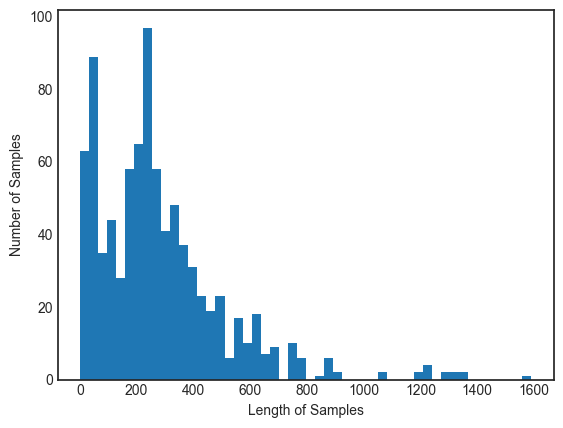

In [826]:
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')

plt.hist([len(s) for s in X_train], bins=50)
plt.xlabel('Length of Samples')
plt.ylabel('Number of Samples')
plt.show()

In [827]:
max_len = 800

In [828]:
X_train = pad_sequences(X_train, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)

In [829]:
embedding_dim = max_len # 임베딩 벡터의 차원
dropout_ratio = 0.4 # 드롭아웃 비율
num_filters = 2 # 커널의 수
kernel_size = 3 # 커널의 크기
hidden_units = 128 # 뉴런의 수

In [830]:
model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))
model.add(Dropout(dropout_ratio))
model.add(Conv1D(num_filters, kernel_size, padding = 'valid', activation = 'relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(hidden_units, activation='relu'))
model.add(Dropout(dropout_ratio))
model.add(Dense(1, activation = 'sigmoid'))

model.summary()

Model: "sequential_39"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_39 (Embedding)    (None, None, 800)         3344000   
                                                                 
 dropout_78 (Dropout)        (None, None, 800)         0         
                                                                 
 conv1d_39 (Conv1D)          (None, None, 2)           4802      
                                                                 
 global_max_pooling1d_39 (G  (None, 2)                 0         
 lobalMaxPooling1D)                                              
                                                                 
 dense_78 (Dense)            (None, 128)               384       
                                                                 
 dropout_79 (Dropout)        (None, 128)               0         
                                                     

In [831]:
es = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 3)
mc = ModelCheckpoint('TextCNN_best_model(learning_rate).h5', monitor = 'val_acc', mode = 'max', verbose = 1, save_best_only = True)

In [832]:
import tensorflow as tf
model.compile(optimizer=tf.keras.optimizers.Nadam(learning_rate = 0.005), loss='binary_crossentropy', metrics = ['acc'])
history = model.fit(X_train, y_train, epochs=10, validation_split = 0.2, callbacks=[es, mc], batch_size = 128)

Epoch 1/10
6/6 [==============================] - ETA: 0s - loss: 0.6972 - acc: 0.4870
Epoch 1: val_acc improved from -inf to 0.61494, saving model to TextCNN_best_model(learning_rate).h5
6/6 [==============================] - 7s 803ms/step - loss: 0.6972 - acc: 0.4870 - val_loss: 0.6912 - val_acc: 0.6149
Epoch 2/10


/Users/yujin/miniforge3/envs/dl_dev_gpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


6/6 [==============================] - ETA: 0s - loss: 0.6960 - acc: 0.5145
Epoch 2: val_acc improved from 0.61494 to 0.62644, saving model to TextCNN_best_model(learning_rate).h5
6/6 [==============================] - 2s 353ms/step - loss: 0.6960 - acc: 0.5145 - val_loss: 0.6903 - val_acc: 0.6264
Epoch 3/10
6/6 [==============================] - ETA: 0s - loss: 0.6593 - acc: 0.6344
Epoch 3: val_acc improved from 0.62644 to 0.65517, saving model to TextCNN_best_model(learning_rate).h5
6/6 [==============================] - 2s 319ms/step - loss: 0.6593 - acc: 0.6344 - val_loss: 0.6293 - val_acc: 0.6552
Epoch 4/10
6/6 [==============================] - ETA: 0s - loss: 0.5447 - acc: 0.7341
Epoch 4: val_acc did not improve from 0.65517
6/6 [==============================] - 2s 305ms/step - loss: 0.5447 - acc: 0.7341 - val_loss: 1.0503 - val_acc: 0.3908
Epoch 5/10
6/6 [==============================] - ETA: 0s - loss: 0.5167 - acc: 0.7413
Epoch 5: val_acc did not improve from 0.65517
6/6 [=

In [833]:
loaded_model = load_model('TextCNN_best_model(learning_rate).h5')
loaded_model.evaluate(X_test, y_test)

17/17 [==============================] - 1s 38ms/step - loss: 0.6712 - acc: 0.6192


[0.671150267124176, 0.6192236542701721]

# TextCNN (ver. Okt)

In [834]:
# sql = 'SELECT token, label FROM Okt_Token'
# okt_token = pd.read_sql(sql, conn)
# okt_token

In [835]:
# import re

# def str_to_list(d):
#   text = re.sub(r'[\[\'\]]', '', d)
#   return text.split(", ")

# news["token"] = news.token.apply(str_to_list)

In [836]:
from tqdm import tqdm
def stopword(x):
  stopword = [r'상승.*', r'하락.*', r'급등.*', r'급락.*', '상승세', '하락세', '폭등', '폭락', '오름세', '약세', '강세', '의', '가', '이', '은', '들', '는', '좀', '잘', '걍', '과', '도', '를', '으로', '자', '에', '와', '한', '하다', '에', '은', '는', '하']
  return [i for i in x if i not in stopword and not i.isdigit()]
tqdm.pandas()
news["token"] = news.token.progress_apply(stopword)
news

100%|██████████| 1407/1407 [00:00<00:00, 5989.60it/s]


,stock_id,date_time,title,content,token,open,high,low,close,volume,Accumulated sales volume,Accumulated number of contract,label,token_okt
0,012450,2023-06-28 14:53:00,"2023 방위산업 부품 장비대전 및 첨단국방산업전, 28일 개막",사이트,[사이트],127000.0,127100.0,126900.0,126900.0,2860.0,250497.0,187111.0,0,['사이트']
1,012450,2023-06-28 14:20:00,"한화에어로, K9 이어 ‘잠수함 배터리’로 인도 시장 정조준 [비즈360]",한화에어로 임원 인도 현지 언론과 인터뷰잠수함용 리튬이온배터리 수출 적극 검토한화에...,"[한화, 어로, 임원, 인도, 현지, 언론, 인터뷰, 잠수함, 용, 리튬, 이온, ...",127400.0,127500.0,127400.0,127500.0,436.0,220243.0,166780.0,1,"['한화', '에어로', '임원', '인도', '현지', '언론', '과', '인터..."
2,012450,2023-06-28 14:20:00,"한화에어로, K9 이어 ‘잠수함 배터리’로 인도 시장 정조준 [비즈360]",한화에어로 임원 인도 현지 언론과 인터뷰잠수함용 리튬이온배터리 수출 적극 검토한화에...,"[한화, 어로, 임원, 인도, 현지, 언론, 인터뷰, 잠수함, 용, 리튬, 이온, ...",127400.0,127500.0,127400.0,127500.0,436.0,220243.0,166780.0,1,"['한화', '에어로', '임원', '인도', '현지', '언론', '과', '인터..."
3,012450,2023-06-28 14:01:00,K-방산수도 대전서 첨단 국방부품·장비 전시 막 올랐다,방산 일자리 박람회 수출상담회 기술교류회 시민 체험행사 등 방위산업 부품장비대전 및...,"[방산, 일자리, 박람회, 수출, 상담, 회, 기술, 교류, 회, 시민, 체험, 행...",127300.0,127400.0,127200.0,127300.0,959.0,210666.0,154389.0,1,"['방산', '일자리', '박람회', '수출', '상담', '회', '기술', '교..."
4,012450,2023-06-28 13:31:00,"과학도시 대전, K-방산의 중심으로 우뚝",방위산업 부품장비대전 및 첨단국방산업전 대전서 개막무인헬기 등 혁신기술 탑재한 제품...,"[방위, 산업, 부품, 장비, 대전, 및, 첨단, 국방, 산업, 전, 대전, 서, ...",128000.0,128000.0,127900.0,128000.0,251.0,198735.0,144178.0,1,"['방위산업', '부품', '장비', '대전', '및', '첨단', '국방', '산..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1402,012450,2021-08-06 09:01:00,"한화에어로스페이스, 2분기 1천326억원 흑자…작년보다 89％↑(종합)",김철선 기자 한화에어로스페이스는 올해 분기 연결기준 매출 조천억원 영업이익 천억원...,"[김, 철선, 기자, 한화, 어로, 스페이스, 올해, 분기, 연결, 기준, 매출, ...",53700.0,53700.0,53500.0,53700.0,12754.0,1501.0,11252.0,1,"['김철', '선', '기자', '한화', '에어로', '스페이스', '는', '올..."
1403,012450,2021-07-30 09:01:00,"백년기업 향하는 한화, 차세대 키워드는 '우주'",미래 모빌리티 항공우주 그린수소 에너지 디지털 금융 솔루션 등 신규 사업에도 세계를...,"[미래, 모, 빌리티, 항공, 우주, 그린, 수소, 에너지, 디지털, 금융, 솔루션...",51700.0,51800.0,51400.0,51800.0,5087.0,1975.0,3112.0,1,"['미래', '모빌리티', '항공우주', '그린', '수소', '에너지', '디지털..."
1404,012450,2021-07-26 10:38:00,"한화에어로스페이스, 다음 달 10일 기업설명회(IR) 개최 예정",서울뉴시스 김제이 기자 한화에어로스페이스는 다음 달 일 오후 시에 투자자 증권사 애...,"[서울, 뉴, 시스, 김, 제이, 기자, 한화, 어로, 스페이스, 다음, 닿, ㄹ,...",51200.0,51300.0,51200.0,51200.0,165.0,95579.0,37613.0,1,"['서울', '뉴시스', '김제', '이', '기자', '한화', '에어로', '스..."
1405,012450,2021-07-01 09:01:00,리노공업·더존비즈온·솔브레인…기술력 독보적인 강소기업 날았다,대한민국 혁신기업 플랫폼미래기술 혁신기업한화솔루션에어로스페이스미래기술 부문에 이름...,"[대한민국, 혁신, 기업, 플랫폼, 미래, 기술, 혁신, 기업, 한화, 솔루션, 어...",46900.0,47000.0,46850.0,46850.0,4322.0,1719.0,2529.0,0,"['대한민국', '혁신', '기업', '플랫폼', '미래', '기술', '혁신', ..."


In [837]:
test = news.loc[news["date_time"] >= '2023-06-01 00:00:00']
train = news.loc[news["date_time"] < '2023-06-01 00:00:00']

X_train = train['token']
y_train = train['label']
X_test = test['token']
y_test = test['label']

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(866,) (866,) (541,) (541,)


In [838]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

In [839]:
threshold = 4
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 6238
등장 빈도가 3번 이하인 희귀 단어의 수: 2491
단어 집합에서 희귀 단어의 비율: 39.93267072779737
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 1.9838712412869088


In [840]:
vocab_size = total_cnt - rare_cnt + 1
print('단어 집합의 크기 :',vocab_size)

단어 집합의 크기 : 3748


In [841]:
tokenizer = Tokenizer(vocab_size, oov_token='OOV')
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [842]:
y_train = np.array(y_train)
y_test = np.array(y_test)

In [843]:
drop_train = [index for index, sentence in enumerate(X_train) if len(sentence) < 1]

X_trian = np.delete(X_train, drop_train, axis=0)
y_train = np.delete(y_train, drop_train, axis=0)

print(len(X_train))
print(len(y_train))

866
866


/Users/yujin/miniforge3/envs/dl_dev_gpu/lib/python3.10/site-packages/numpy/lib/function_base.py:5071: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asarray(arr)


In [844]:
print('뉴스 최대 길이:', max(len(l) for l in X_train))
print('뉴스 평균 길이:', sum(map(len, X_trian)) / len(X_train))

뉴스 최대 길이: 1700
뉴스 평균 길이: 272.3464203233256


/var/folders/j6/q03gf6y53_72jb_wzwbp2b140000gn/T/ipykernel_3386/1955333591.py:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-white')


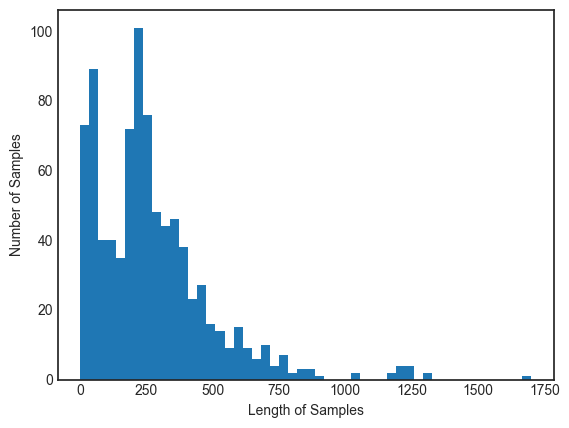

In [845]:
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')

plt.hist([len(s) for s in X_train], bins=50)
plt.xlabel('Length of Samples')
plt.ylabel('Number of Samples')
plt.show()

In [846]:
max_len = 800

In [847]:
X_train = pad_sequences(X_train, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)

In [848]:
embedding_dim = max_len # 임베딩 벡터의 차원
dropout_ratio = 0.4 # 드롭아웃 비율
num_filters = 2 # 커널의 수
kernel_size = 3 # 커널의 크기
hidden_units = 128 # 뉴런의 수

In [849]:
model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))
model.add(Dropout(dropout_ratio))
model.add(Conv1D(num_filters, kernel_size, padding = 'valid', activation = 'relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(hidden_units, activation='relu'))
model.add(Dropout(dropout_ratio))
model.add(Dense(1, activation = 'sigmoid'))

In [850]:
es = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 3)
mc = ModelCheckpoint('TextCNN_best_model(okt).h5', monitor = 'val_acc', mode = 'max', verbose = 1, save_best_only = True)

In [851]:
import tensorflow as tf
model.compile(optimizer=tf.keras.optimizers.Nadam(learning_rate = 0.005), loss='binary_crossentropy', metrics = ['acc'])
history = model.fit(X_train, y_train, epochs=10, validation_split = 0.2, callbacks=[es, mc], batch_size = 128)

Epoch 1/10
6/6 [==============================] - ETA: 0s - loss: 0.6966 - acc: 0.4884
Epoch 1: val_acc improved from -inf to 0.62069, saving model to TextCNN_best_model(okt).h5
6/6 [==============================] - 6s 617ms/step - loss: 0.6966 - acc: 0.4884 - val_loss: 0.6813 - val_acc: 0.6207
Epoch 2/10


/Users/yujin/miniforge3/envs/dl_dev_gpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


6/6 [==============================] - ETA: 0s - loss: 0.6845 - acc: 0.5751
Epoch 2: val_acc did not improve from 0.62069
6/6 [==============================] - 2s 420ms/step - loss: 0.6845 - acc: 0.5751 - val_loss: 0.7353 - val_acc: 0.3736
Epoch 3/10
6/6 [==============================] - ETA: 0s - loss: 0.6043 - acc: 0.6821
Epoch 3: val_acc did not improve from 0.62069
6/6 [==============================] - 2s 363ms/step - loss: 0.6043 - acc: 0.6821 - val_loss: 0.7924 - val_acc: 0.4598
Epoch 4/10
6/6 [==============================] - ETA: 0s - loss: 0.4960 - acc: 0.7616
Epoch 4: val_acc did not improve from 0.62069
6/6 [==============================] - 2s 292ms/step - loss: 0.4960 - acc: 0.7616 - val_loss: 0.9180 - val_acc: 0.4828
Epoch 4: early stopping


In [852]:
loaded_model = load_model('TextCNN_best_model(okt).h5')
loaded_model.evaluate(X_test, y_test)

17/17 [==============================] - 1s 35ms/step - loss: 0.6718 - acc: 0.6784


[0.6717503666877747, 0.678373396396637]

In [863]:
from konlpy.tag import Okt
okt = Okt()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def sentiment_predict(new_sentence):
  new_sentence = okt.morphs(new_sentence, stem=True) # 토큰화
  new_sentence = [word for word in new_sentence if not word in stopwords] # 불용어 제거
  encoded = tokenizer.texts_to_sequences([new_sentence]) # 정수 인코딩
  pad_new = pad_sequences(encoded, maxlen = max_len) # 패딩
  score = float(model.predict(pad_new)) # 예측
  if(score > 0.6):
    print("{:.2f}% 확률로 긍정 리뷰입니다.\n".format(score * 100))
  else:
    print("{:.2f}% 확률로 부정 리뷰입니다.\n".format((1 - score) * 100))
     